In [36]:
import os
import random

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200 #make plots bigger

import cv2
import xml.etree.ElementTree as ET

import tensorflow as tf
print(tf.__version__)
assert(tf.test.is_gpu_available())
from keras.preprocessing.image import load_img, img_to_array
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

!pip install keras-unet

PROCESSING_DIM = 512 #divisible by 32 for u-net
BATCHSIZE = 8
TARGET_RES = 380

from google.colab import drive
drive.mount('/content/gdrive')
PATH = './gdrive/My Drive/goban_data_set/'
#PATH = './'
CHECKPOINT_PATH = PATH+'CornerSegmentationUNet.h5'

1.14.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
K.clear_session()

In [0]:
def mirror_half(img, y):
    if random.random() < 0.5:
        return img, y
    else:
        img_mirrored = img[:,::-1].copy() # y,x,c
        y_mirrored = y.copy()
        # walk through x coordinates and mirror
        for i in range(0, y.shape[0], 2):
            y_mirrored[i] = 999 - y[i] #based on coordinates for 1000x1000
        # swap left and right corners
            y_mirrored_copy = y_mirrored.copy()
            y_mirrored[0: 2] = y_mirrored_copy[6: 8]
            y_mirrored[2: 4] = y_mirrored_copy[4: 6]
            y_mirrored[4: 6] = y_mirrored_copy[2: 4]
            y_mirrored[6: 8] = y_mirrored_copy[0: 2]
        return img_mirrored, y_mirrored
        
def random_cutout(img, labels, max_cutout=50):
    #print(f"labels: {labels}")
    labels = labels.astype('float32')
    left_space = np.amin(labels[::2]) - 1
    right_space = 999 - np.amax(labels[::2])
    top_space = np.amin(labels[1::2]) - 1
    bottom_space = 999 - np.amax(labels[1::2])
    
    safe_space = min(left_space, right_space, top_space, bottom_space)
    safe_space = min(safe_space, max_cutout) #TODO: change other versions of notebook to min as well

    rand_left = random.randint(0, safe_space)
    rand_right = random.randint(0, safe_space)
    horizontal_total = rand_left + rand_right
    rand_top = random.randint(0, safe_space)
    rand_bottom = horizontal_total - rand_top #keeps aspect ratio
    
    cutoff_left = rand_left
    cutoff_top = rand_top
    cutoff_right = 999 - rand_right
    cutoff_bottom = 999 - rand_bottom
    
    cutout = img[cutoff_top:cutoff_bottom, cutoff_left:cutoff_right]
    
    for xcoord in range(0, len(labels), 2):
        labels[xcoord] =  labels[xcoord] * (1000 / (1000 - rand_right))
        
        labels[xcoord] = 999 - labels[xcoord]
        labels[xcoord] =  labels[xcoord] * (1000 / (1000 - rand_left))
        labels[xcoord] = 999 - labels[xcoord]
        
    for ycoord in range(1, len(labels), 2):
        labels[ycoord] = labels[ycoord] * (1000 / (1000 - rand_bottom))
        
        labels[ycoord] = 999 - labels[ycoord]
        labels[ycoord] =  labels[ycoord] * (1000 / (1000 - rand_top))
        labels[ycoord] = 999 - labels[ycoord]
    
    labels = np.rint(labels)
    labels = labels.astype('uint16')
    return cutout, labels

def train_gen():
    files = os.listdir(PATH + 'training_images_for_labels/')
    X = np.zeros((BATCHSIZE, PROCESSING_DIM, PROCESSING_DIM, 1), dtype=np.float32)
    Y = np.zeros((BATCHSIZE, PROCESSING_DIM, PROCESSING_DIM, 1), dtype=np.float32)
    while True:
        for i, file in enumerate(random.sample(files, BATCHSIZE)):
            y = np.zeros((8), dtype=np.uint16)
            points = {}
            tree = ET.parse(PATH+'training_corner_labels/'+file.rstrip('png')+'xml')
            root = tree.getroot()
            for obj in root.findall('object'):
                tag = obj.find('name').text
                x_coord = np.uint16(obj.find('point').find('x1').text)
                y_coord = np.uint16(obj.find('point').find('y1').text)
                points[tag] = [x_coord,y_coord]
            y[0:2] = points['ul_board_corner']
            y[2:4] = points['dl_board_corner']
            y[4:6] = points['dr_board_corner']
            y[6:8] = points['ur_board_corner']

            filename=PATH+'training_images_for_labels/'+file
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)
            img, y = random_cutout(img, y)
            img = cv2.resize(img, dsize=(PROCESSING_DIM,PROCESSING_DIM), 
                             interpolation=cv2.INTER_LINEAR)
            mirror_half(img, y)
            img = (img / 255.) - 0.5
            X[i,::,::,0] = img

            mask = np.zeros((1000, 1000), np.uint8)
            cv2.fillConvexPoly(mask, np.reshape(y, (-1,2)).astype('int32'), 255)
            mask = cv2.resize(mask, dsize=(PROCESSING_DIM,PROCESSING_DIM), 
                         interpolation=cv2.INTER_LINEAR)
            mask = mask / 255.
            Y[i,::,::,0] = mask
        yield (X, Y)
        
def val_gen():
    files = os.listdir(PATH + 'validation_images/')
    X = np.zeros((len(files), PROCESSING_DIM, PROCESSING_DIM, 1), dtype=np.float32)
    Y = np.zeros((len(files), PROCESSING_DIM, PROCESSING_DIM, 1), dtype=np.float32)
    while True:
        for i, file in enumerate(files):
            y = np.zeros((len(files)), dtype=np.uint16)
            points = {}
            tree = ET.parse(PATH+'validation_labels/'+file.rstrip('png')+'xml')
            root = tree.getroot()
            for obj in root.findall('object'):
                tag = obj.find('name').text
                x_coord = np.uint16(obj.find('point').find('x1').text)
                y_coord = np.uint16(obj.find('point').find('y1').text)
                points[tag] = [x_coord,y_coord]
            y[0:2] = points['ul_board_corner']
            y[2:4] = points['dl_board_corner']
            y[4:6] = points['dr_board_corner']
            y[6:8] = points['ur_board_corner']

            filename=PATH+'validation_images/'+file
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)
            img = cv2.resize(img, dsize=(PROCESSING_DIM,PROCESSING_DIM), 
                             interpolation=cv2.INTER_LINEAR)
            img = (img / 255.) - 0.5
            X[i,::,::,0] = img

            mask = np.zeros((1000, 1000), np.uint8)
            cv2.fillConvexPoly(mask, np.reshape(y, (-1,2)).astype('int32'), 255)
            mask = cv2.resize(mask, dsize=(PROCESSING_DIM,PROCESSING_DIM), 
                             interpolation=cv2.INTER_LINEAR)
            mask = mask / 255.
            Y[i,::,::,0] = mask
        yield (X, Y)
    

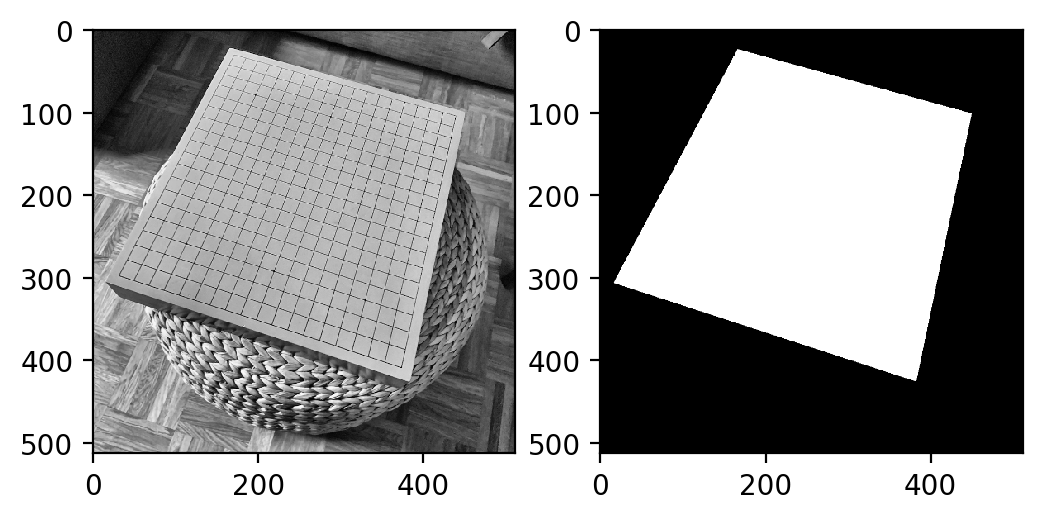

In [24]:
# TEST TRAINGEN
sample = next(train_gen())
x, y = sample
i = random.randrange(0, BATCHSIZE)
img1 = x[i,::,::,0]
img2 = y[i,::,::,0]
#print(img1.shape, np.max(img1), img1.dtype)
#print(img2.shape, np.max(img2), img2.dtype)
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img1, interpolation='nearest', cmap='gray', vmin=-0.5, vmax=0.5)
f.add_subplot(1,2, 2)
plt.imshow(img2, interpolation='nearest', cmap='gray', vmin=0, vmax=1)
plt.show(block=True)

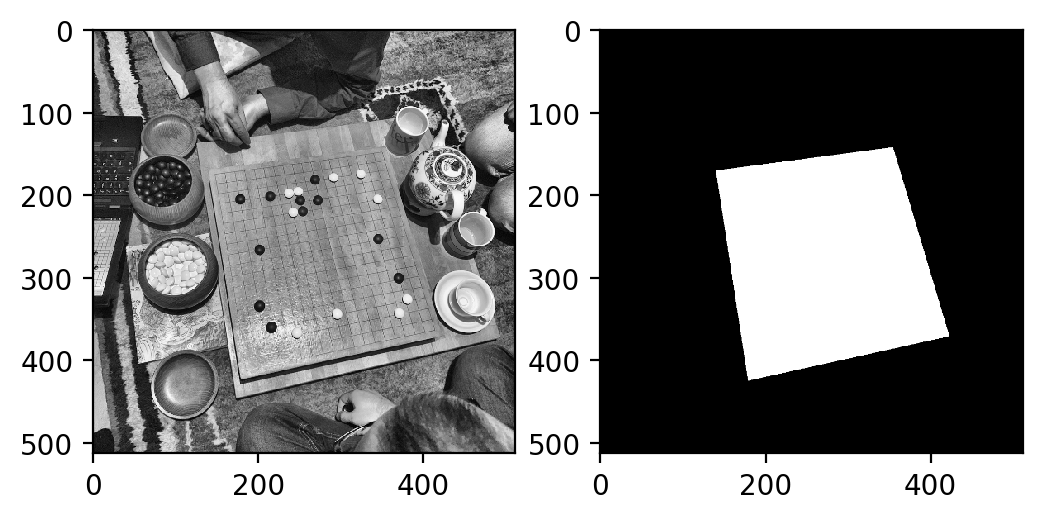

In [29]:
# TEST VALGEN
sample = next(val_gen())
x, y = sample
i = random.randrange(0, 8)
img1 = x[i,::,::,0]
img2 = y[i,::,::,0]
#print(img1.shape, np.max(img1), img1.dtype)
#print(img2.shape, np.max(img2), img2.dtype)
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img1, interpolation='nearest', cmap='gray', vmin=-0.5, vmax=0.5)
f.add_subplot(1,2, 2)
plt.imshow(img2, interpolation='nearest', cmap='gray', vmin=0, vmax=1)
plt.show(block=True)

In [30]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(PROCESSING_DIM, PROCESSING_DIM, 1),
    use_batch_norm=True,
    upsample_mode='deconv',
    num_classes=1,
    filters=16,
    dropout=0,
    num_layers=4,
    output_activation='sigmoid')
model.summary()

W0824 20:26:20.547768 140538436773760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 20:26:20.551702 140538436773760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 20:26:20.563040 140538436773760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0824 20:26:20.608010 140538436773760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0824 20:26:20.609238

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [31]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

#model = load_model(CHECKPOINT_PATH, custom_objects={'iou': iou, 'iou_thresholded': iou_thresholded})

model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              #loss=jaccard_distance,
              metrics=[iou, iou_thresholded])

W0824 20:26:30.919589 140538436773760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0824 20:26:30.931679 140538436773760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [34]:
checkpointing = ModelCheckpoint(CHECKPOINT_PATH, 
                                  verbose=0, 
                                  monitor='val_loss', 
                                  save_best_only=True)
history = model.fit_generator(
                    train_gen(),
                    steps_per_epoch=55,
                    epochs=100,
                    validation_data=val_gen(),
                    validation_steps=1,
                    callbacks=[checkpointing],
                    verbose=1)

Epoch 1/100
55/55 [==============================] - 100s 2s/step - loss: 0.3477 - iou: 0.5887 - iou_thresholded: 0.7574 - val_loss: 0.8841 - val_iou: 0.6226 - val_iou_thresholded: 0.6456
Epoch 2/100
55/55 [==============================] - 67s 1s/step - loss: 0.1683 - iou: 0.7700 - iou_thresholded: 0.9007 - val_loss: 0.3497 - val_iou: 0.7623 - val_iou_thresholded: 0.7866
Epoch 3/100
55/55 [==============================] - 40s 719ms/step - loss: 0.1099 - iou: 0.8489 - iou_thresholded: 0.9392 - val_loss: 0.1827 - val_iou: 0.8456 - val_iou_thresholded: 0.8758
Epoch 4/100
55/55 [==============================] - 40s 719ms/step - loss: 0.0927 - iou: 0.8727 - iou_thresholded: 0.9443 - val_loss: 0.1176 - val_iou: 0.8637 - val_iou_thresholded: 0.9042
Epoch 5/100
55/55 [==============================] - 40s 718ms/step - loss: 0.0746 - iou: 0.9004 - iou_thresholded: 0.9591 - val_loss: 0.0897 - val_iou: 0.8859 - val_iou_thresholded: 0.9267
Epoch 6/100
55/55 [==============================] - 40

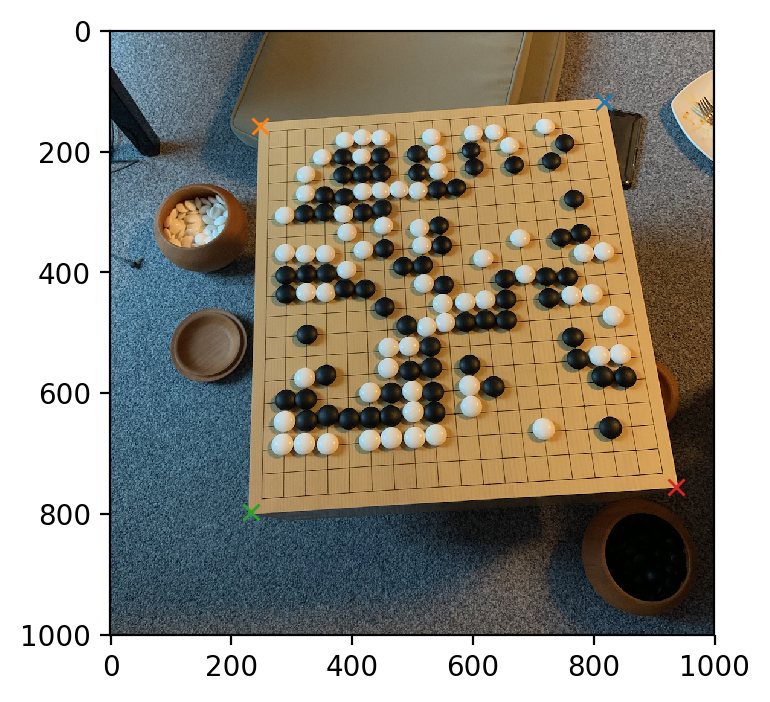

In [35]:
def predict_once(filename, model):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = cv2.resize(img, dsize=(PROCESSING_DIM,PROCESSING_DIM), 
                             interpolation=cv2.INTER_LINEAR)
    img = (img / 255.) - 0.5
    plt.imshow(img, interpolation='nearest', cmap='gray', vmin=-0.5, vmax=0.5)
    img = np.expand_dims(img, axis=2) #keras wants color channel dim
    img = (np.expand_dims(img, axis=0)) #keras expects batch shape
    prediction = model.predict(img)
    prediction = np.squeeze(prediction) #drop batch and color dim for matplot
    prediction = (prediction > 0.5) * 1.
    #plt.imshow(prediction, interpolation='nearest', cmap='gray', vmin=0, vmax=1)
    return prediction

def find_corners(prediction):
    gray = (prediction * 255.).astype('uint8')
      
    # find contours (i.e. the 'outlines') in the image:
    _, cnts, _ = cv2.findContours(gray.copy(), 
                                    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # sort by area and keep only largest ten for better performance
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]    

    # loop over the contours
    area_prev = 0.0
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, closed=True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, closed=True)  # 0.02
        # if the approximated contour has four points assume it is the goban
        if (len(approx) == 4 and cv2.contourArea(approx) > area_prev):
            area_prev = cv2.contourArea(approx)
            corners = approx
    corners = np.reshape(corners, (4, 2))
    return corners

def mark_corners_in_original(filename, corners):
    img = cv2.imread(filename)
    plt.imshow(img[::,::,::-1])
    
    corners = corners * 1000 / PROCESSING_DIM
    for (col, row) in corners:
        plt.plot(col,row, 'x')
    
    
filename = PATH + 'validation_images/' + 'IMG_1213.png'
prediction = predict_once(filename, model)
corners = find_corners(prediction)
mark_corners_in_original(filename, corners)

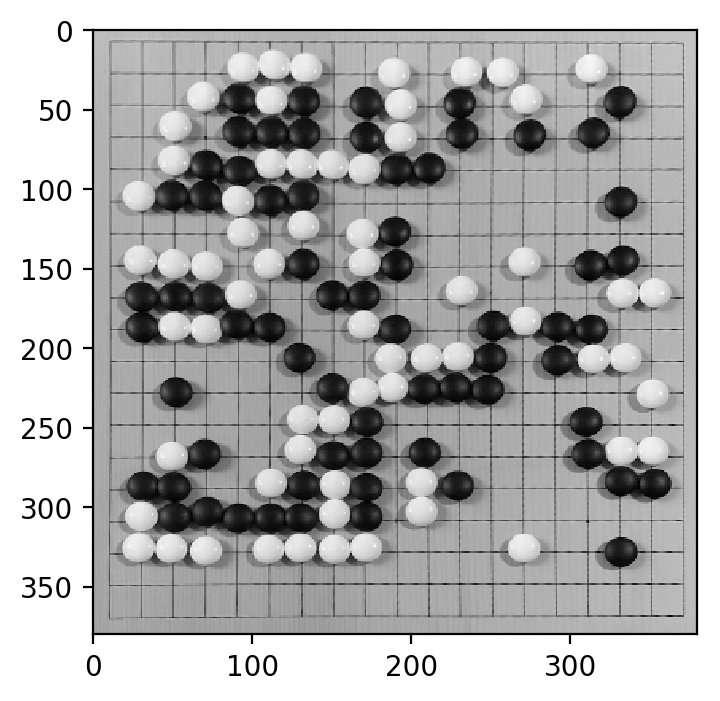

In [45]:
def sort_corners(corners):
    rect = np.zeros((4, 2), dtype="float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = np.sum(corners, axis=1)
    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(corners, axis=1)
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]
    return rect

def warp_to_gray(filename, rect):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    target_corners = np.float32([[0, 0], [TARGET_RES, 0],
                                [TARGET_RES, TARGET_RES], [0, TARGET_RES]])
    rect = rect * 1000 / PROCESSING_DIM
    M = cv2.getPerspectiveTransform(rect, target_corners)
    warped = cv2.warpPerspective(gray, M, (TARGET_RES, TARGET_RES))
    plt.imshow(warped, cmap='gray')
    return warped

rect = sort_corners(corners)
warped = warp_to_gray(filename, rect)